In [1]:
# Imports
from music21 import converter, instrument, note, chord, stream, midi
import glob
import time
import numpy as np
import keras.utils as utils
import pandas as pd

Using TensorFlow backend.


# Convert between MIDI files and numpy arrays in melody format



In [2]:
# Melody Events.
# MIDI Notes are between 0 - 127, so use
MELODY_NOTE_OFF = 128 # -1 # 128
MELODY_NO_EVENT = 129 # -2 # 129


def streamToNoteArray(stream):
    """
    Convert a Music21 sequence to a numpy array of int8s in Magenta melody format:
        0-127 - note on at specified pitch
        -1    - note off
        -2    - no event
    """
    # Part one, extract from stream
    total_length = np.int(np.round(stream.flat.highestTime / 0.25)) # in semiquavers
    stream_list = []
    for element in stream.flat:
        if isinstance(element, note.Note):
            stream_list.append([np.round(element.offset / 0.25), np.round(element.quarterLength / 0.25), element.pitch.midi])
        elif isinstance(element, chord.Chord):
            stream_list.append([np.round(element.offset / 0.25), np.round(element.quarterLength / 0.25), element.sortAscending().pitches[-1].midi])
    np_stream_list = np.array(stream_list, dtype=np.int)
    df = pd.DataFrame({'pos': np_stream_list.T[0], 'dur': np_stream_list.T[1], 'pitch': np_stream_list.T[2]})
    df = df.sort_values(['pos','pitch'], ascending=[True, False]) # sort the dataframe properly
    df = df.drop_duplicates(subset=['pos']) # drop duplicate values
    # part 2, convert into a sequence of note events
    output = np.zeros(total_length+1, dtype=np.int16) + np.int16(MELODY_NO_EVENT)  # set array full of no events by default.
    # Fill in the output list
    for i in range(total_length):
        if not df[df.pos==i].empty:
            n = df[df.pos==i].iloc[0] # pick the highest pitch at each semiquaver
            output[i] = n.pitch # set note on
            output[i+n.dur] = MELODY_NOTE_OFF
    return output


def noteArrayToDataFrame(note_array):
    """
    Convert a numpy array containing a Magenta melody sequence into a music21 stream.
    """
    df = pd.DataFrame({"code": note_array})
    df['offset'] = df.index
    df['duration'] = df.index
    df = df[df.code != MELODY_NO_EVENT]
    df.duration = df.duration.diff(-1) * -1 * 0.25  # calculate durations and change to quarter note fractions
    df = df.fillna(0.25)
    return df[['code','duration']]


def noteArrayToStream(note_array):
    """
    Convert a numpy array containing a Magenta melody sequence into a music21 stream.
    """
    df = noteArrayToDataFrame(note_array)
    melody_stream = stream.Stream()
    for index, row in df.iterrows():
        if row.code < 0:
            new_note = note.Rest()
        else:
            new_note = note.Note(row.code)
        new_note.quarterLength = row.duration
        melody_stream.append(new_note)
    return melody_stream


In [94]:
## Play a melody stream
# sp = midi.realtime.StreamPlayer(melody_stream)
# sp.play()

## Construct a dataset of popular Zelda melodies

Open some zelda midi files and extract the melodies as numpy note sequence arrays.

In [3]:
# test_midi = converter.parse(loz_midi_files[2])
# print("Length:", np.int(np.round(test_midi.flat.highestTime / 0.25))) # in semiquavers

In [2]:
# import time
# loz_midi_files = glob.glob("/Users/charles/src/zelda-mid/loz-*.mid")
# midi_files = glob.glob("/Users/charles/src/zelda-mid/*.mid")



In [9]:
# test_midi.parts[0].show()

In [11]:
import time
loz_midi_files = glob.glob("/Users/charles/src/zelda-mid/loz-*.mid")
midi_files = glob.glob("/Users/charles/src/zelda-mid/*.mid")

training_arrays = []
for f in midi_files:
    start = time.clock()
    try:
        s = converter.parse(f)
    except:
        continue
    arr = streamToNoteArray(s.parts[0])
    training_arrays.append(arr)
    print("Converted:", f, "it took", time.clock() - start)

training_dataset = np.array(training_arrays)
np.savez('melody_training_dataset.npz', train=training_dataset)

Converted: /Users/charles/src/zelda-mid/z64oot-z64shop.mid it took 0.9873979999999989
Converted: /Users/charles/src/zelda-mid/loz-Title08.mid it took 1.2644809999999964
Converted: /Users/charles/src/zelda-mid/lozoos-taamuruins.mid it took 15.877151000000005
Converted: /Users/charles/src/zelda-mid/lozmm-Termina.mid it took 10.766751
Converted: /Users/charles/src/zelda-mid/z64oot-z64inwml.mid it took 1.511412
Converted: /Users/charles/src/zelda-mid/lozoos-Zelda-_Windmill_2.mid it took 0.741297000000003
Converted: /Users/charles/src/zelda-mid/lozph-PHboss_ship.mid it took 1.6072680000000048
Converted: /Users/charles/src/zelda-mid/loz-Title09.mid it took 0.3678329999999903
Converted: /Users/charles/src/zelda-mid/lozww-Dawn.mid it took 0.7721289999999925
Converted: /Users/charles/src/zelda-mid/z64oot-z64intro.mid it took 0.7769020000000069
Converted: /Users/charles/src/zelda-mid/lozww-The_king_of_hyrule.mid it took 0.8215320000000048
Converted: /Users/charles/src/zelda-mid/lozoos-Zelda-_Win

Converted: /Users/charles/src/zelda-mid/loz-Dungeon04.mid it took 0.38083699999998544
Converted: /Users/charles/src/zelda-mid/loz-Dungeon10.mid it took 2.221993999999995
Converted: /Users/charles/src/zelda-mid/loz-Dungeon06.mid it took 0.5965419999999995
Converted: /Users/charles/src/zelda-mid/loz-Overworld01.mid it took 1.0618329999999787
Converted: /Users/charles/src/zelda-mid/lozph-linebeck_001.mid it took 0.6403460000000223
Converted: /Users/charles/src/zelda-mid/lozph-Linebeck.mid it took 1.0812020000000189
Converted: /Users/charles/src/zelda-mid/loz-OverworldRemix02.mid it took 2.2887620000000197
Converted: /Users/charles/src/zelda-mid/loz-OverworldRemix03.mid it took 6.767319999999984
Converted: /Users/charles/src/zelda-mid/Z4catfish.mid it took 30.052436999999998
Converted: /Users/charles/src/zelda-mid/lozph-Heart.mid it took 0.0786820000000148
Converted: /Users/charles/src/zelda-mid/z2-z2title.mid it took 1.2895340000000033
Converted: /Users/charles/src/zelda-mid/loz-Dungeon07

# Load Training Data and Create RNN

In [3]:
# Training Hyperparameters:
VOCABULARY_SIZE = 130 # known 0-127 notes + 128 note_off + 129 no_event
SEQ_LEN = 30
BATCH_SIZE = 64
HIDDEN_UNITS = 256
EPOCHS = 30
SEED = 2345  # 2345 seems to be good.
np.random.seed(SEED)

In [4]:
with np.load('./melody_training_dataset.npz') as data:
    train_set = data['train']
    
# train_set = [a.astype(np.int16) for a in train_set] # change to int16

# for arr in train_set:
#     arr[arr == -1] = 128 # new value for MELODY_NOTE_OFF
#     arr[arr == -2] = 129 # new value for MELODY_NO_EVENT

print("Training melodies:", len(train_set))

Training melodies: 186


In [7]:
def slice_sequence_examples(sequence, num_steps):
    xs = []
    for i in range(len(sequence) - num_steps - 1):
        example = sequence[i: i + num_steps]
        xs.append(example)
    #print("Total training examples:", str(len(xs)))
    return xs

def seq_to_singleton_format(examples):
    """
    Return the examples in seq to singleton format.
    """
    xs = []
    ys = []
    for ex in examples:
        xs.append(ex[:-1])
        ys.append(ex[-1])
    return (xs,ys)

# Prepare training data as X and Y.
slices = []
for seq in train_set:
    slices +=  slice_sequence_examples(seq, SEQ_LEN+1)
X, y = seq_to_singleton_format(slices)

X = np.array(X)
y = np.array(y)

print("Total Training Corpus:")
print("X:", X.shape)
print("y:", y.shape)

Total Training Corpus:
X: (122250, 30)
y: (122250,)


# Define the Training RNN

In [10]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers.embeddings import Embedding
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
from keras.models import load_model

In [128]:
# build the model: a single LSTM
print('Build model...')
model_train = Sequential()
model_train.add(Embedding(VOCABULARY_SIZE, HIDDEN_UNITS, input_length=SEQ_LEN))

# LSTM part
model_train.add(LSTM(HIDDEN_UNITS, return_sequences=True))
model_train.add(LSTM(HIDDEN_UNITS))

# Project back to vocabulary
model_train.add(Dense(VOCABULARY_SIZE, activation='softmax'))
model_train.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model_train.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 256)           33280     
_________________________________________________________________
lstm_5 (LSTM)                (None, 30, 256)           525312    
_________________________________________________________________
lstm_6 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_3 (Dense)              (None, 130)               33410     
Total params: 1,117,314
Trainable params: 1,117,314
Non-trainable params: 0
_________________________________________________________________


# Training

In [125]:
model_train.fit(X, y, batch_size=BATCH_SIZE, epochs=EPOCHS)
model_train.save("zeldic-rnn.h5")

Epoch 1/100
 10048/129069 [=>............................] - ETA: 5:45 - loss: 3.0500

KeyboardInterrupt: 

In [12]:
# Load if necessary
#model_train = keras.Model.load("zeldic-rnn.h5")

AttributeError: type object 'Model' has no attribute 'load'

In [13]:
# Build a decoding model (input length 1, batch size 1, stateful)
model_dec = Sequential()
model_dec.add(Embedding(VOCABULARY_SIZE, HIDDEN_UNITS, input_length=1, batch_input_shape=(1,1)))
# LSTM part
model_dec.add(LSTM(HIDDEN_UNITS, stateful=True, return_sequences=True))
model_dec.add(LSTM(HIDDEN_UNITS, stateful=True))

# project back to vocabulary
model_dec.add(Dense(VOCABULARY_SIZE, activation='softmax'))
model_dec.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model_dec.summary()
# set weights from training model
#model_dec.set_weights(model_train.get_weights())
model_dec.load_weights("zeldic-rnn.h5")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, 1, 256)               33280     
_________________________________________________________________
lstm_1 (LSTM)                (1, 1, 256)               525312    
_________________________________________________________________
lstm_2 (LSTM)                (1, 256)                  525312    
_________________________________________________________________
dense_1 (Dense)              (1, 130)                  33410     
Total params: 1,117,314
Trainable params: 1,117,314
Non-trainable params: 0
_________________________________________________________________


# Sampling from the Model

In [14]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [15]:
## Sampling function

def sample_model(seed, model_name, length=400):
    '''Samples a musicRNN given a seed sequence.'''
    generated = []  
    generated.append(seed)
    next_index = seed
    for i in range(length):
        x = np.array([next_index])
        x = np.reshape(x,(1,1))
        preds = model_name.predict(x, verbose=0)[0]
        next_index = sample(preds, 1.0)        
        generated.append(next_index)
    return np.array(generated)

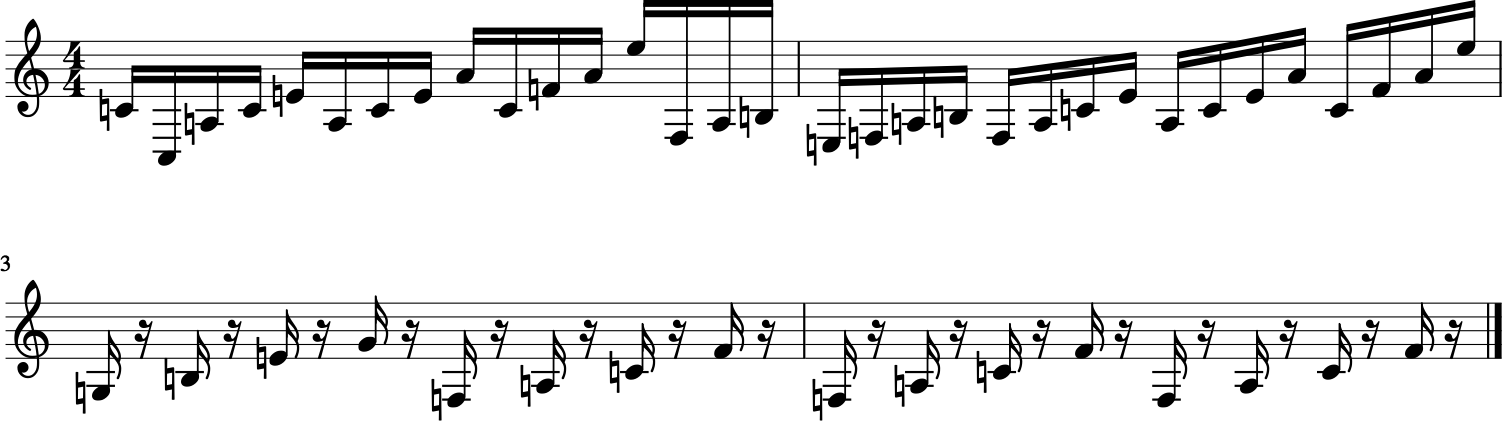

In [22]:
model_dec.reset_states()
o = sample_model(60, model_dec, length=63)
o[o == 128] = -1 # put back melody_note_off
o[o == 129] = -2 # put back melody_no_event

melody_stream = noteArrayToStream(o)
melody_stream.show()


# Play back generated Melody

In [23]:
## Pay a melody stream
sp = midi.realtime.StreamPlayer(melody_stream)
sp.play()